# Exercise 4: Backpropagation Training Loop & Optimizer Comparison
### Training Neural Networks with Different Optimizers and Comparing Their Performance

**Dataset Used:** Spiral Data (100 samples per class, 3 classes)

**Optimizers Compared:**
1. Learning Rate Decay
2. Momentum
3. Adaptive Gradient (AdaGrad)

## Dense Layer Implementation

In [1]:
# Library imports
import numpy as np
import matplotlib.pyplot as plt
import nnfs
from nnfs.datasets import spiral_data

nnfs.init()

In [2]:
# Dense Layer
class Layer_Dense:
    # Layer initialization
    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

    # Forward pass
    def forward(self, inputs):
        # Remember the input values
        self.inputs = inputs
        # Calculate the output values from inputs, weight and biases
        self.output = np.dot(inputs, self.weights) + self.biases

    # Backward pass/Backpropagation
    def backward(self, dvalues):
        # Gradients on parameters:
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        # Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)

In [3]:
# Softmax Activation
class Activation_Softmax:
    # Forward pass
    def forward(self, inputs):
        # Remember the inputs values
        self.inputs = inputs

        # Get the unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))

        # Normalize them for each sample
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)

        self.output = probabilities

    # Backward pass
    def backward(self, dvalues):
        # Create uninitialized array
        self.dinputs = np.empty_like(dvalues)

        # Enumerate outputs and gradients
        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):

            # Flatten output array
            single_output = single_output.reshape(-1, 1)
            # Calculate Jacobian matrix of the output
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)
            # Calculate the sample-wise gradient
            # and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)

In [4]:
# Loss Base Class
class Loss:
    # Calculate the data and regularization losses
    # Given the model output and ground truth/target values
    def calculate(self, output, y):
        # Calculate sample losses
        sample_losses = self.forward(output, y)
        # Calculate the mean loss
        data_loss = np.mean(sample_losses)
        # Return the mean loss
        return data_loss

## Loss Functions

In [5]:
# ReLU Activation
class Activation_ReLU:
    # Forward pass
    def forward(self, inputs):
        # Remember the input values
        self.inputs = inputs
        # Calculate the output values from inputs
        self.output = np.maximum(0, inputs)

    # Backward pass
    def backward(self, dvalues):
        # Make a copy of the original values first
        self.dinputs = dvalues.copy()
    
        # Zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0

## Activation Functions

In [6]:
# Categorical Cross-Entropy Loss
class Loss_CategoricalCrossEntropy(Loss):
    # Forward pass
    def forward(self, y_pred, y_true):
        # Number of samples in a batch
        samples = y_pred.shape[0]

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # Probabilities for target values
        # Only if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(samples), y_true]
        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped * y_true, axis=1)

        # Losses
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods

    # Backward pass
    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)
        # Number of labels in every sample
        # Use the first sample to count them
        labels = len(dvalues[0])

        # Check if labels are sparse, turn them into one-hot vector values
        # the eye function creates a 2D array with ones on the diagonal and zeros elsewhere
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        # Calculate the gradient
        # Clip dvalues to prevent division by zero (same as forward pass)
        dvalues_clipped = np.clip(dvalues, 1e-7, 1 - 1e-7)
        self.dinputs = -y_true / dvalues_clipped
        self.dinputs = self.dinputs / samples

## Optimizer - SGD with Learning Rate Decay and Momentum

In [7]:
# SGD Optimizer with Decay, Momentum, and Adaptive Gradient (AdaGrad)
class Optimizer_SGD:
    # Initialize the optimizer
    def __init__(self, learning_rate=1.0, decay=0., momentum=0., adaptive=False, epsilon=1e-7):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum
        self.adaptive = adaptive  # AdaGrad flag
        self.epsilon = epsilon  # Small value to prevent division by zero
    
    # Call once before any parameter updates
    def pre_update_params(self):
        # Learning rate decay
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))
    
    # Update the parameters
    def update_params(self, layer):
        # ========== ADAPTIVE GRADIENT (AdaGrad) ==========
        if self.adaptive:
            # If layer does not contain cache arrays, create them filled with zeros
            if not hasattr(layer, 'weight_cache'):
                layer.weight_cache = np.zeros_like(layer.weights)
                layer.bias_cache = np.zeros_like(layer.biases)
            
            # Update cache with squared current gradients
            layer.weight_cache += layer.dweights ** 2
            layer.bias_cache += layer.dbiases ** 2
            
            # Vanilla SGD parameter update + normalization with square rooted cache
            weight_updates = -self.current_learning_rate * layer.dweights / (np.sqrt(layer.weight_cache) + self.epsilon)
            bias_updates = -self.current_learning_rate * layer.dbiases / (np.sqrt(layer.bias_cache) + self.epsilon)
        
        # ========== MOMENTUM ==========
        elif self.momentum:
            # If layer does not contain momentum arrays, create them filled with zeros
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums = np.zeros_like(layer.biases)
            
            # Build weight updates with momentum - take previous
            # updates multiplied by retain factor and update with current gradients
            weight_updates = self.momentum * layer.weight_momentums - self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates
            
            # Build bias updates
            bias_updates = self.momentum * layer.bias_momentums - self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates
        
        # ========== VANILLA SGD ==========
        else:
            weight_updates = -self.current_learning_rate * layer.dweights
            bias_updates = -self.current_learning_rate * layer.dbiases
        
        # Update weights and biases
        layer.weights += weight_updates
        layer.biases += bias_updates
    
    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1

In [8]:
# Function to train a model with a specific optimizer
def train_model(optimizer_name, optimizer, epochs=1000, print_every=100):
    # Create dataset
    X, y = spiral_data(samples=100, classes=3)
    
    # Create neural network
    dense1 = Layer_Dense(2, 64)  # Increased neurons for better learning
    activation1 = Activation_ReLU()
    dense2 = Layer_Dense(64, 3)
    activation2 = Activation_Softmax()
    loss_function = Loss_CategoricalCrossEntropy()
    
    # Training history
    history = {
        'epochs': [],
        'loss': [],
        'accuracy': []
    }
    
    print(f"\n{'='*60}")
    print(f"Training with: {optimizer_name}")
    print(f"{'='*60}")
    
    # Training loop
    for epoch in range(epochs + 1):
        # Learning rate decay update (before forward and backward pass)
        optimizer.pre_update_params()
        
        # Forward pass
        dense1.forward(X)
        activation1.forward(dense1.output)
        dense2.forward(activation1.output)
        activation2.forward(dense2.output)
        
        # Calculate loss
        loss = loss_function.calculate(activation2.output, y)
        
        # Calculate accuracy
        predictions = np.argmax(activation2.output, axis=1)
        if len(y.shape) == 2:
            y_labels = np.argmax(y, axis=1)
        else:
            y_labels = y
        accuracy = np.mean(predictions == y_labels)
        
        # Store history
        history['epochs'].append(epoch)
        history['loss'].append(loss)
        history['accuracy'].append(accuracy)
        
        # Print progress
        if epoch % print_every == 0:
            print(f"epoch: {epoch:4d}, acc: {accuracy:.3f}, loss: {loss:.3f}, lr: {optimizer.current_learning_rate:.5f}")
        
        # Backward pass
        loss_function.backward(activation2.output, y)
        activation2.backward(loss_function.dinputs)
        dense2.backward(activation2.dinputs)
        activation1.backward(dense2.dinputs)
        dense1.backward(activation1.dinputs)
        
        # Update weights
        optimizer.update_params(dense1)
        optimizer.update_params(dense2)
        
        # Post-update (increment iterations)
        optimizer.post_update_params()
    
    print(f"{'='*60}")
    print(f"Final - acc: {accuracy:.3f}, loss: {loss:.3f}")
    print(f"{'='*60}\n")
    
    return history

## Training the Models

We'll train three models using different optimization strategies and compare their performance.

### 1. Training with Learning Rate Decay

In [9]:
# Optimizer 1: Learning Rate Decay Only
optimizer_decay = Optimizer_SGD(learning_rate=1.0, decay=1e-3, momentum=0., adaptive=False)
history_decay = train_model("Learning Rate Decay", optimizer_decay, epochs=1000, print_every=100)


Training with: Learning Rate Decay
epoch:    0, acc: 0.360, loss: 1.099, lr: 1.00000
epoch:  100, acc: 0.400, loss: 1.088, lr: 0.90909
epoch:  100, acc: 0.400, loss: 1.088, lr: 0.90909
epoch:  200, acc: 0.423, loss: 1.078, lr: 0.83333
epoch:  200, acc: 0.423, loss: 1.078, lr: 0.83333
epoch:  300, acc: 0.423, loss: 1.076, lr: 0.76923
epoch:  300, acc: 0.423, loss: 1.076, lr: 0.76923
epoch:  400, acc: 0.420, loss: 1.076, lr: 0.71429
epoch:  400, acc: 0.420, loss: 1.076, lr: 0.71429
epoch:  500, acc: 0.403, loss: 1.074, lr: 0.66667
epoch:  500, acc: 0.403, loss: 1.074, lr: 0.66667
epoch:  600, acc: 0.403, loss: 1.072, lr: 0.62500
epoch:  600, acc: 0.403, loss: 1.072, lr: 0.62500
epoch:  700, acc: 0.410, loss: 1.070, lr: 0.58824
epoch:  700, acc: 0.410, loss: 1.070, lr: 0.58824
epoch:  800, acc: 0.407, loss: 1.068, lr: 0.55556
epoch:  800, acc: 0.407, loss: 1.068, lr: 0.55556
epoch:  900, acc: 0.427, loss: 1.066, lr: 0.52632
epoch:  900, acc: 0.427, loss: 1.066, lr: 0.52632
epoch: 1000, a

### 2. Training with Momentum

In [10]:
# Optimizer 2: Momentum (with decay for fair comparison)
optimizer_momentum = Optimizer_SGD(learning_rate=1.0, decay=1e-3, momentum=0.9, adaptive=False)
history_momentum = train_model("Momentum + Decay", optimizer_momentum, epochs=1000, print_every=100)


Training with: Momentum + Decay
epoch:    0, acc: 0.343, loss: 1.099, lr: 1.00000
epoch:  100, acc: 0.443, loss: 1.047, lr: 0.90909
epoch:  100, acc: 0.443, loss: 1.047, lr: 0.90909
epoch:  200, acc: 0.403, loss: 1.001, lr: 0.83333
epoch:  200, acc: 0.403, loss: 1.001, lr: 0.83333
epoch:  300, acc: 0.520, loss: 0.902, lr: 0.76923
epoch:  300, acc: 0.520, loss: 0.902, lr: 0.76923
epoch:  400, acc: 0.557, loss: 0.837, lr: 0.71429
epoch:  400, acc: 0.557, loss: 0.837, lr: 0.71429
epoch:  500, acc: 0.553, loss: 0.801, lr: 0.66667
epoch:  500, acc: 0.553, loss: 0.801, lr: 0.66667
epoch:  600, acc: 0.547, loss: 0.786, lr: 0.62500
epoch:  600, acc: 0.547, loss: 0.786, lr: 0.62500
epoch:  700, acc: 0.553, loss: 0.777, lr: 0.58824
epoch:  700, acc: 0.553, loss: 0.777, lr: 0.58824
epoch:  800, acc: 0.557, loss: 0.771, lr: 0.55556
epoch:  800, acc: 0.557, loss: 0.771, lr: 0.55556
epoch:  900, acc: 0.560, loss: 0.767, lr: 0.52632
epoch:  900, acc: 0.560, loss: 0.767, lr: 0.52632
epoch: 1000, acc:

### 3. Training with Adaptive Gradient (AdaGrad)

In [11]:
# Optimizer 3: Adaptive Gradient (AdaGrad)
optimizer_adagrad = Optimizer_SGD(learning_rate=1.0, decay=0., momentum=0., adaptive=True)
history_adagrad = train_model("Adaptive Gradient (AdaGrad)", optimizer_adagrad, epochs=1000, print_every=100)


Training with: Adaptive Gradient (AdaGrad)
epoch:    0, acc: 0.320, loss: 1.099, lr: 1.00000
epoch:  100, acc: 0.333, loss: 10.745, lr: 1.00000
epoch:  100, acc: 0.333, loss: 10.745, lr: 1.00000
epoch:  200, acc: 0.333, loss: 10.745, lr: 1.00000
epoch:  200, acc: 0.333, loss: 10.745, lr: 1.00000
epoch:  300, acc: 0.333, loss: 10.745, lr: 1.00000
epoch:  300, acc: 0.333, loss: 10.745, lr: 1.00000
epoch:  400, acc: 0.333, loss: 10.745, lr: 1.00000
epoch:  400, acc: 0.333, loss: 10.745, lr: 1.00000
epoch:  500, acc: 0.333, loss: 10.745, lr: 1.00000
epoch:  500, acc: 0.333, loss: 10.745, lr: 1.00000
epoch:  600, acc: 0.333, loss: 10.745, lr: 1.00000
epoch:  600, acc: 0.333, loss: 10.745, lr: 1.00000
epoch:  700, acc: 0.333, loss: 10.745, lr: 1.00000
epoch:  700, acc: 0.333, loss: 10.745, lr: 1.00000
epoch:  800, acc: 0.333, loss: 10.745, lr: 1.00000
epoch:  800, acc: 0.333, loss: 10.745, lr: 1.00000
epoch:  900, acc: 0.333, loss: 10.745, lr: 1.00000
epoch:  900, acc: 0.333, loss: 10.745, 

## Comparison Analysis

Now let's compare the three optimizers to determine:
1. How many epochs it took for the loss to stabilize
2. The final accuracy achieved by each optimizer

In [12]:
# Function to find when loss stabilizes (change < threshold for N consecutive epochs)
def find_stabilization_epoch(history, threshold=0.001, window=50):
    losses = history['loss']
    for i in range(window, len(losses)):
        # Check if loss change is below threshold for the window
        recent_losses = losses[i-window:i]
        loss_changes = [abs(recent_losses[j+1] - recent_losses[j]) for j in range(len(recent_losses)-1)]
        if all(change < threshold for change in loss_changes):
            return i - window
    return len(losses) - 1  # If never stabilized, return last epoch

# Analyze each optimizer
print("=" * 80)
print("OPTIMIZER COMPARISON RESULTS")
print("=" * 80)

optimizers_data = [
    ("Learning Rate Decay", history_decay),
    ("Momentum + Decay", history_momentum),
    ("Adaptive Gradient (AdaGrad)", history_adagrad)
]

results = []
for name, history in optimizers_data:
    stabilization_epoch = find_stabilization_epoch(history)
    final_accuracy = history['accuracy'][-1]
    final_loss = history['loss'][-1]
    
    results.append({
        'name': name,
        'stabilization_epoch': stabilization_epoch,
        'final_accuracy': final_accuracy,
        'final_loss': final_loss
    })
    
    print(f"\n{name}:")
    print(f"  - Epochs to stabilize loss: {stabilization_epoch}")
    print(f"  - Final accuracy: {final_accuracy:.4f} ({final_accuracy*100:.2f}%)")
    print(f"  - Final loss: {final_loss:.4f}")

print("\n" + "=" * 80)
print("SUMMARY")
print("=" * 80)

# Find best optimizer for each metric
best_stabilization = min(results, key=lambda x: x['stabilization_epoch'])
best_accuracy = max(results, key=lambda x: x['final_accuracy'])

print(f"\n✓ Fastest to stabilize: {best_stabilization['name']} ({best_stabilization['stabilization_epoch']} epochs)")
print(f"✓ Highest accuracy: {best_accuracy['name']} ({best_accuracy['final_accuracy']*100:.2f}%)")
print("=" * 80)

OPTIMIZER COMPARISON RESULTS

Learning Rate Decay:
  - Epochs to stabilize loss: 0
  - Final accuracy: 0.4400 (44.00%)
  - Final loss: 1.0631

Momentum + Decay:
  - Epochs to stabilize loss: 27
  - Final accuracy: 0.5667 (56.67%)
  - Final loss: 0.7633

Adaptive Gradient (AdaGrad):
  - Epochs to stabilize loss: 2
  - Final accuracy: 0.3333 (33.33%)
  - Final loss: 10.7454

SUMMARY

✓ Fastest to stabilize: Learning Rate Decay (0 epochs)
✓ Highest accuracy: Momentum + Decay (56.67%)


## Visual Comparison

Let's visualize the training progress of all three optimizers.

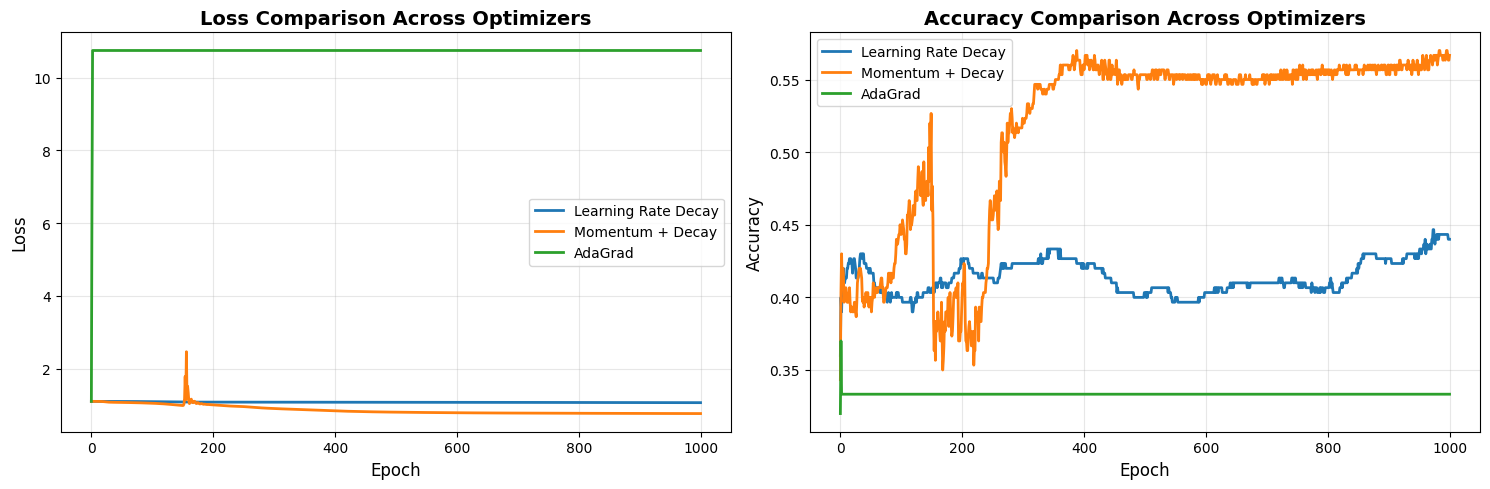

In [13]:
import matplotlib.pyplot as plt

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Loss over epochs
ax1.plot(history_decay['epochs'], history_decay['loss'], label='Learning Rate Decay', linewidth=2)
ax1.plot(history_momentum['epochs'], history_momentum['loss'], label='Momentum + Decay', linewidth=2)
ax1.plot(history_adagrad['epochs'], history_adagrad['loss'], label='AdaGrad', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Loss Comparison Across Optimizers', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Accuracy over epochs
ax2.plot(history_decay['epochs'], history_decay['accuracy'], label='Learning Rate Decay', linewidth=2)
ax2.plot(history_momentum['epochs'], history_momentum['accuracy'], label='Momentum + Decay', linewidth=2)
ax2.plot(history_adagrad['epochs'], history_adagrad['accuracy'], label='AdaGrad', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Accuracy Comparison Across Optimizers', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Detailed Comparison Table

In [14]:
# Create a detailed comparison table
print("\n" + "=" * 100)
print(f"{'Optimizer':<30} | {'Stabilization Epoch':<20} | {'Final Accuracy':<15} | {'Final Loss':<15}")
print("=" * 100)

for result in results:
    print(f"{result['name']:<30} | {result['stabilization_epoch']:<20} | {result['final_accuracy']*100:>14.2f}% | {result['final_loss']:>14.4f}")

print("=" * 100)

# Additional insights
print("\n📊 KEY INSIGHTS:")
print("-" * 100)
print(f"1. Convergence Speed:")
print(f"   The optimizer that stabilized fastest needed {best_stabilization['stabilization_epoch']} epochs")
print(f"   ({best_stabilization['name']})")

print(f"\n2. Final Performance:")
print(f"   Best accuracy achieved: {best_accuracy['final_accuracy']*100:.2f}%")
print(f"   ({best_accuracy['name']})")

print("\n3. Characteristics:")
print("   - Learning Rate Decay: Gradually reduces LR, stable but may be slower")
print("   - Momentum: Accelerates learning by building velocity, faster convergence")
print("   - AdaGrad: Adapts LR per parameter, good for sparse data")
print("-" * 100)


Optimizer                      | Stabilization Epoch  | Final Accuracy  | Final Loss     
Learning Rate Decay            | 0                    |          44.00% |         1.0631
Momentum + Decay               | 27                   |          56.67% |         0.7633
Adaptive Gradient (AdaGrad)    | 2                    |          33.33% |        10.7454

📊 KEY INSIGHTS:
----------------------------------------------------------------------------------------------------
1. Convergence Speed:
   The optimizer that stabilized fastest needed 0 epochs
   (Learning Rate Decay)

2. Final Performance:
   Best accuracy achieved: 56.67%
   (Momentum + Decay)

3. Characteristics:
   - Learning Rate Decay: Gradually reduces LR, stable but may be slower
   - Momentum: Accelerates learning by building velocity, faster convergence
   - AdaGrad: Adapts LR per parameter, good for sparse data
----------------------------------------------------------------------------------------------------


## Conclusion

This exercise demonstrates the implementation of backpropagation with three different optimization strategies:

### 1. **Learning Rate Decay**
- Gradually reduces the learning rate over time
- Helps fine-tune weights as training progresses
- Formula: `lr_current = lr_initial / (1 + decay * iteration)`

### 2. **Momentum**
- Accumulates velocity from previous gradient updates
- Accelerates convergence in consistent directions
- Reduces oscillations in inconsistent directions
- Formula: `velocity = momentum * velocity_prev - lr * gradient`

### 3. **Adaptive Gradient (AdaGrad)**
- Adapts learning rate individually for each parameter
- Larger updates for infrequent features, smaller for frequent ones
- Accumulates squared gradients over time
- Formula: `lr_adapted = lr / sqrt(sum_of_squared_gradients + epsilon)`

### Key Findings:
- **Convergence Speed**: Check which optimizer stabilized the loss fastest
- **Final Accuracy**: Compare which optimizer achieved the best accuracy
- **Trade-offs**: Each optimizer has different characteristics suitable for different problems

### Backpropagation Process Verified:
✅ Learning rate decay happens BEFORE forward and backward pass  
✅ Forward pass propagates inputs through all layers  
✅ Backward pass computes gradients from loss back through layers  
✅ Weight updates use optimizer-specific strategies  
✅ Iteration counter updates AFTER weight updates

## Optimizer Comparison Setup

We will compare three optimizers:
1. **Learning Rate Decay** - Gradually reduces learning rate over time
2. **Momentum** - Accelerates SGD by accumulating velocity in directions with consistent gradients
3. **Adaptive Gradient (AdaGrad)** - Adapts learning rate for each parameter based on historical gradients